# Soft Computing - rač. vežba 3

## K-means algoritam
Cilj ovih vežbi jeste implementacija K-means algoritma za grupisanje i njegova primena u OCR-u, kroz Scikit-learn biblioteku.
* Scikit-learn - biblioteka za mašinsko učenje u Python-u (http://scikit-learn.org/stable/)

### Algoritam
Pomoću K-Means algoritma moguće je izvršiti podelu prostora na k grupa, gde je svaka od njih određena svojom centralnom tačkom. Svrstavanje nekog elementa u jednu od grupa se svodi na određivanje njemu najbižeg centra, po Euklidskom rastojanju.
<img src="images/plot_kmeans.png"></img>
#### Ulazni parametri algoritma
Za rad K-Means algoritma neophodno je poznavati broj grupa u napred.

#### Pseudo-kod
```code
za svaku grupu inicijalizovati nasumično centar
dok se centri ne prestanu kretati za predodređeni minimum ili ne dostigne predodređeni broj iteracija radi:
    pridruži svaki element iz skupa grupi sa njemu najbližim centrom
    pomeri centar svih grupa na osnovu novih elemenata
```

In [2]:
#import potrebnih biblioteka za K-means algoritam
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans
iris = datasets.load_iris() #Iris dataset koji će se koristiti kao primer https://en.wikipedia.org/wiki/Iris_flower_data_set

###Pomoćna funkcija za ispis
Funkcija će biti korišćena kako bi se prikazala konvergencija K-means algoritma kroz svaku iteraciju.

In [3]:
def display_progress(data, centers, labels):
    '''
    Funkcija služi za debagovanje postupka pomeranja grupa
    '''
    colors = iter(plt.cm.gist_rainbow(np.linspace(0,1,len(centers)))) #formira se iterabilna lista od n različitih boja
    for idx, center in enumerate(centers):
        center_group = data[np.where(labels == idx)] #niz tačaka koje pripadaju grupi određenoj centrom 'center'
        color = next(colors) #uzima se boja za svaku grupu
        plt.scatter(center_group[:,0],center_group[:,1], c=color, marker='o', s=50) #iscrtavanje tačaka u grupi
        plt.scatter(center[0],center[1], c=color, marker='x', s=200) #iscrtavanje centara
    plt.show()

#TODO 1
Implementirati funkciju koja vraća dve nasumično odabrane tačke iz niza

In [4]:
#Explicitnim postavljanjem seed-a za random vrednosti, možemo da kontrolišemo rešenje algoritma
np.random.seed(6);

def init_centers(data, n_clusters):
    '''
    Funkcija vraća niz od 'n_clusters' tačaka koje su nasumično odabrane.
    Args:
        data: niz tačaka koje se klasifikuju.
        n_clusters: broj grupa na koje se podaci klasifikuju.
    Return:
        niz tačaka koji određuju centre grupa.
    '''
    centers = []
    for _ in range(0, n_clusters):
        rnd_idx = np.random.randint(0, len(data))
        centers.append(data[rnd_idx])
        
    return np.array(centers)

#TODO 2
Implementirati funkciju koja računa rastojanje između dve tačke. Ova funkcija će biti upotrebljena kako bi se odredio pomeraj centara grupa iz iteracije u iteraciju, kao i pripadnost neke tačke određenoj grupi.

In [5]:
def get_distance(pt1, pt2):
    '''
    Funkcija implementira izračunavanje rastojanja između dve tačke
    Args:
        pt1, pt2: vektori koji određuju tačke
    Return:
        rastojanje između tačaka
    '''
    # NAPOMENA: nisam siguran koliko je ovo neophodno, ali eventualno bi bilo korisno napomenuti
    # kakve se sve funkcije rastojanja mogu koristiti. Na primer zašto je square distance dovoljan, i ne mora pravo
    # Euklidsko rastojanje.
    return distance.sqeuclidean(pt1, pt2)

#TODO 3
Implementirati funkciju koja vraća pripadnost prosleđenih tačaka grupama. Ovo je glavna funkcija koja će se koristiti nakon što se centri grupa odrede, ali igra ulogu i tokom same konvergencije K-means algoritma.

In [6]:
def predict(data, centers):
    '''
    Funkcija implementira predikciju pripadnusti svake tačke iz niza 'data', za grupe
    koje su određene centrima iz niza 'centers'
    Args:
        data: niz tačaka koje treba klasifikovati
        centers: kalkulisani centri grupa
    Return:
        Niz čiji elementi sadrže indeks grupe kojoj element na toj poziciji odgovara
    Primer:
        data = [[1,1], [2,2], [3,3]]
        centers = [[1,1], [4,4]]
        ret_val = [0, 0, 1]
    '''
    ret_val = []
    for point in data:
        center_distance = []
        for center in centers:
            center_distance.append(get_distance(point, center))
        
        minimum = min(enumerate(center_distance), key=lambda x: x[1])[0]
        ret_val.append(minimum)
    
    return np.array(ret_val)

#TODO 4
Implementirati funkciju koja koristi podatke o pripadnosti grupama određenih tačaka, dobijeni iz funkcije predict, i izračunava nove centre kao srednje tačke određenih grupa.

In [7]:
def shift_centers(data, centers, labels):
    '''
    Funkcija implementira pomeranje prosleđenih centara grupa u odnosu na trenutnu pripadnost
    tačaka, opisanu kroz niz labels.
    Args:
        data: niz tačaka koje se klasifikuju
        centers: niz tačaka koje određuju trenutne centre
        labels: niz koji određuje pripadnost tačaka iz 'data', predstavlja vrednost koja se dobije iz 'predict'
            funkcije iz prethodnog zadatka.
    Return:
        (np.array, float) Funkcija treba da vrati izračunate nove centre na osnovu vrednosti koje pripadaju grupi,
            i ukupno rastojanje za koje su se centri pomerili
    '''
    ret_val = []
    total_shift = 0
    for idx, center in enumerate(centers):
        center_group = data[np.where(labels == idx)]
        if len(center_group) > 0:
            new_center = np.sum(center_group, axis=0) / float(len(center_group))
        else:
            new_center = center
            
        ret_val.append(new_center)
        total_shift += get_distance(new_center, center)
    
    return np.array(ret_val), total_shift

#TODO 5
Implementirati glavnu petlju algoritma.

In [8]:
def fit_clusters(data, n_clusters, tolerance, max_iter, verbose = False):
    '''
    Funkcija treba da implementira glavnu petlju koja formira grupe.
    Args:
        data: niz koje je potrebno klasifikovati.
        n_clusters: broj grupa na koje se prostor deli.
        tolerance: uslov prekida algoritma koji se upoređuje sa ukupnim pomerajem centara iz iteracije
            u iteraciju.
        max_iter: drugi uslov prekida algoritma koji određuje maksimalni broj iteracija.
        verbose: određuje da li će se prikazivati grafici trenutnog stanja u svakoj iteraciji.
    Return:
        Povratna vrednost predstavlja niz od 'n_clusters' tačaka koje odgovaraju centrima grupa.
    '''
    centers = init_centers(data, n_clusters)
    data = np.array(data, float)

    for iteration in range(0, max_iter):
        labels = predict(data, centers)      
        new_centers, shift = shift_centers(data, centers, labels)
        if(verbose):
            print 'Iteration:', iteration+1, '\nMean shift:', shift
            display_progress(data, centers, labels)
            
        centers = new_centers
        
        if(shift < tolerance):
            break;
        
    return centers

#Primer na <i>Iris</i> dataset-u
Na slici su prikazane stvarne vrednosti parametara za sve tri klase <i>Iris</i> cveta. Iscrtani grafici predstavljaju prikaze u odnosu na po dve osobine cveta.
<img src="images/Anderson's_Iris_data_set.png" height="70%" width="70%"></img>

#Start
Prvo se određuju centri, zatim se nad tim centrima može izvršiti predikcija za neku drugu tačku.

Iteration: 1 
Mean shift: 4.44672690472


/home/stefan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


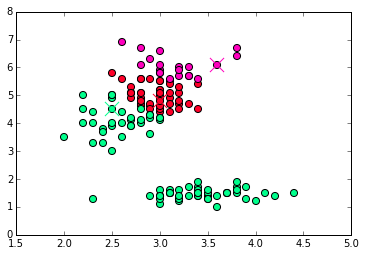

Iteration: 2 
Mean shift: 0.857115945244


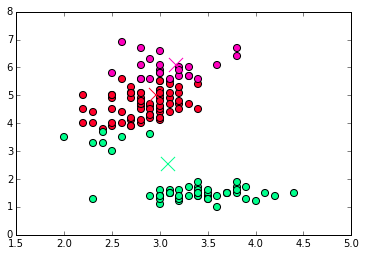

Iteration: 3 
Mean shift: 0.10763735512


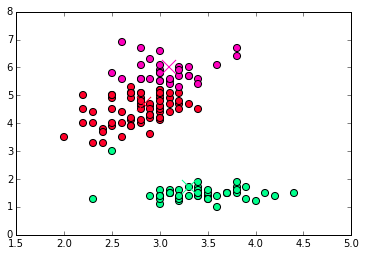

Iteration: 4 
Mean shift: 0.00807567589074


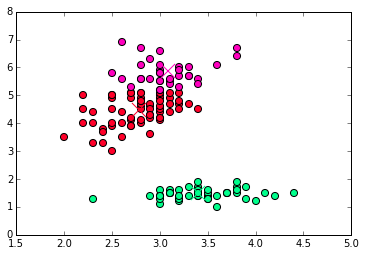

Iteration: 5 
Mean shift: 0.00222559455473


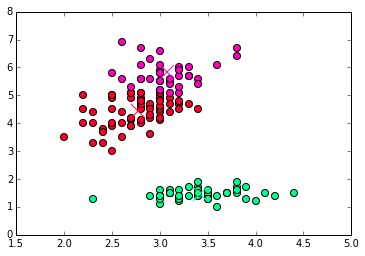

Iteration: 6 
Mean shift: 0.000482378979522


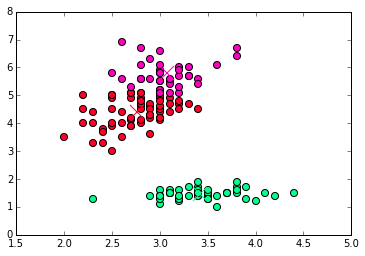

Iteration: 7 
Mean shift: 0.0


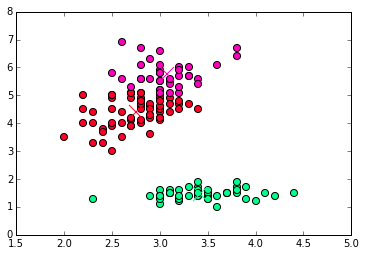

Centri: [[ 2.75396825  4.4       ]
 [ 3.418       1.464     ]
 [ 3.07297297  5.76756757]]
Grupa za tacku [1,4]: [0]


In [9]:
data = iris.data[:,1:3] #Odgovara Sepal.Width i Petal.Length osobinama
calculated_centers = fit_clusters(data, 3, 0.00001, 5000, True)
print 'Centri:', calculated_centers

print 'Grupa za tacku [1,4]:',predict([[1,4]], calculated_centers)

#Scikit-learn K-Means implementacija
Pomenuta scikit-learn biblioteka sadrži već implementiran K-Means algoritam koji ćemo koristiti u buduće.

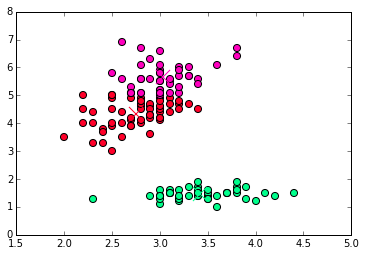

[[ 2.75087719  4.32807018]
 [ 3.418       1.464     ]
 [ 3.03255814  5.67209302]]


In [10]:
k_means = KMeans(n_clusters=3, max_iter=5000, init='random', tol=0.00001, n_init=10)
k_means.fit(data)
display_progress(data, k_means.cluster_centers_, k_means.labels_)
print k_means.cluster_centers_


#Primena u OCR-u
Do sada je rađeno optičko prepoznavanje brojeva i matematičkih izraza. Kada je reč o čitanju stvarnog teksta, deo problema predstavlja i određivanje granica između reči i redova u tekstu. Kao rešenje moguće je koristiti K-means algoritam i klasifikovati razmak između regiona na dve grupe:
* Razmak između slova u reči
* Razmak između reči

In [11]:
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [12]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

#TODO 6
Modifikovati funkciju za određivanje regija od interesa, tako da vraća i vrednosti rastojanja po x osi, između svih regiona.

In [13]:
def select_roi(image_orig, image_bin):
    '''
    Funkcija kao u vežbi 2, iscrtava pravougaonike na originalnoj slici, pronalazi sortiran niz regiona sa slike,
    i dodatno treba da sačuva rastojanja između susednih regiona.
    '''
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Način određivanja kontura je promenjen na spoljašnje konture: cv2.RETR_EXTERNAL
    regions_dict = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1,x:x+w+1];
        regions_dict[x] = [resize_region(region), (x,y,w,h)] #Proširuje dictionary informacijama o pravougaoniku
        cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

#TODO 7
U odnosu na alfabet prikazan na slici, definisati i obučiti neuronsku mrežu.
<img src="images/alphabet.png"></img>

In [50]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='tanh'))
    ann.add(Dense(26, activation='tanh'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

Broj prepoznatih regiona: 26


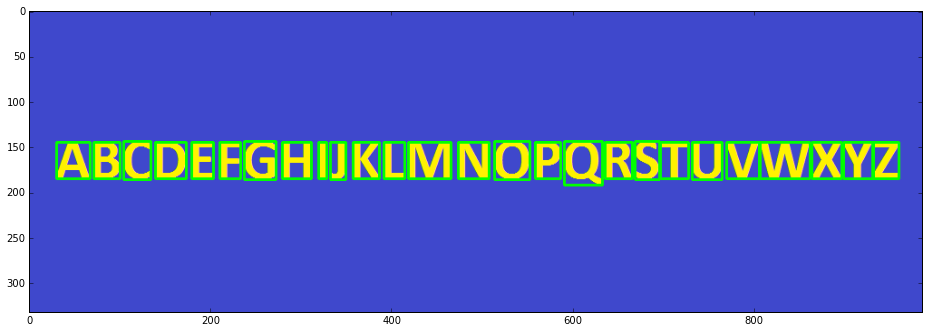

In [57]:
image_color = load_image('images/alphabet.png')
img = image_bin(image_gray(image_color))
selected_regions, letters, region_distances = select_roi(image_color.copy(), img)
display_image(selected_regions)
print 'Broj prepoznatih regiona:', len(letters)

In [52]:
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
inputs = prepare_for_ann(letters)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

#Iščitavanje pune rečenice.
Prvo se učitava slika, i određuju regioni od interesa kao i rastojanje među njima. Nakon toga, određuju se centri
dve grupe rastojanja K-means algoritmom.

Broj prepoznatih regiona: 22


KMeans(copy_x=True, init='k-means++', max_iter=2000, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=1e-05,
    verbose=0)

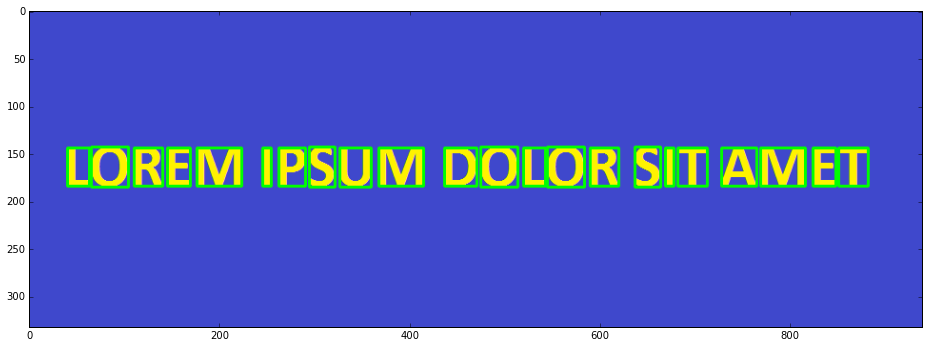

In [59]:
#Učitavanje slike i određivanje regiona od interesa
image_color = load_image('images/LoremIpsum.png')
img = image_bin(image_gray(image_color))
selected_regions, letters, distances = select_roi(image_color.copy(), img)
display_image(selected_regions)
print 'Broj prepoznatih regiona:', len(letters)

#Podešavanje centara grupa K-means algoritmom
distances = np.array(distances).reshape(len(distances), 1)
#Neophodno je da u K-means algoritam bude prosleđena matrica u kojoj vrste određuju elemente

k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means.fit(test)

#TODO 8
Promeniti funkciju za prikaz tako da formira string sa razmacima između reči.

In [54]:
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        result += alphabet[winner(output)]
    return result

#Izvršavanje predikcije

In [56]:
inputs = prepare_for_ann(letters)
results = ann.predict(np.array(inputs, np.float32))
print display_result(results, alphabet, k_means)

LOREM IPSUM DOLOR SIT AMET


#TODO dodatno
Proširiti algoritam mogućnošću da prepoznaje redove. Primer slike za prepoznavanje je
<i>images/Dodatno.png</i>